# E-tivity 2 Weeks 3-4

* Barry Clarke

* 24325082

## Outline

This e-tivity is split into two parts. The first part <a href="#part1">**Stock Predicition**</a> is a group activity where you are tasked with predicting the stock market.

The second <a href="#part2">**Sentiment Analysis**</a> is an individual task, the problem is to predict if a film review is positive or negative.

### Guidelines

The e-tivity is split into five tasks. The first four are "group" excersises, in that you post the solutions to Tasks 1-4 to the Group Locker. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to Brightspace.

Marks will be deducted if task 5 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-5 and with correct identification or filename.


Grading guidelines: the rubrics for the e-tivity are here https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4446&originTool=quicklinks





<a id='part1'></a>
## Stock Prediction

### Context

There is a small dataset of real stock prices for each working day from the end of 2015 to the end of 2019. There are four variables (with a time stamp), stock price, oil price, gold price and Euro to Dollar exchange. You need to predict the Stock price a day ahead from only the past values of each of the 4 variables.


### Tasks 1-4 (complete by Sunday Week 4)

Create additional cells to complete the tasks below. These form the group exercises and you can upload your code for Tasks 1-4 to the group locker.

**Task 1: data preprocessing**

Explain any preprocessing steps you take including but limited to reformatting and also how you have selected the training and test sets. The test set should be 20% of the whole.

**Task 2: data cleaning**

There are a number of missing values in the data. Clean the data so that it is suitable for use with the NN. Bare in mind that you want to retain the time coherency of the data as much as possible. Explain the steps you have taken.

**Task 3: model construction**

Construct a RNN network that will predict the future value of Stock, one day/time inteval in advance.

**Task 4: test**

Evaluate the model on the test set and display any change in accuracy over time, if any. Test for common issues found in deep learning models.

### Post (complete by Sunday Week 3)

Please upload your code for Tasks 1-4 to the group locker by Sunday if possible. The implementation does not need to be complete and you can continue to upload improved versions. The link is below. To organise things well; create a new subfolder in the locker for your work. You can upload multiple copies with different filenames to archive development stages. Post the link to the forum/topic. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

Post the location to the appropriate forum/topic.

No posts should reference Task 5.

### Respond (complete by Wednesday Week 4)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

The group interaction forms part of the overall assessment. Grading guidelines for the forum posts: the rubrics for the e-tivity are here
https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4446&originTool=quicklinks

### Final Submission (complete by Sunday Week 4)

Submit Tasks 1-5 in a single notebook this before the deadline on Sunday.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

Input Shape: (1021, 10, 4)
Training Samples: 816, Test Samples: 205
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0018 - val_loss: 1.6703e-04
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1647e-04 - val_loss: 1.5634e-04
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3160e-04 - val_loss: 1.4963e-04
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6906e-04 - val_loss: 1.4743e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6006e-04 - val_loss: 1.5172e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3645e-04 - val_loss: 1.4590e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3661e-04 - val_loss: 1.4939e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1792e-04 - val_loss: 1.4569e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0442e-04 - val_loss: 1.5149e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0801e-04 - val_loss: 1.4296

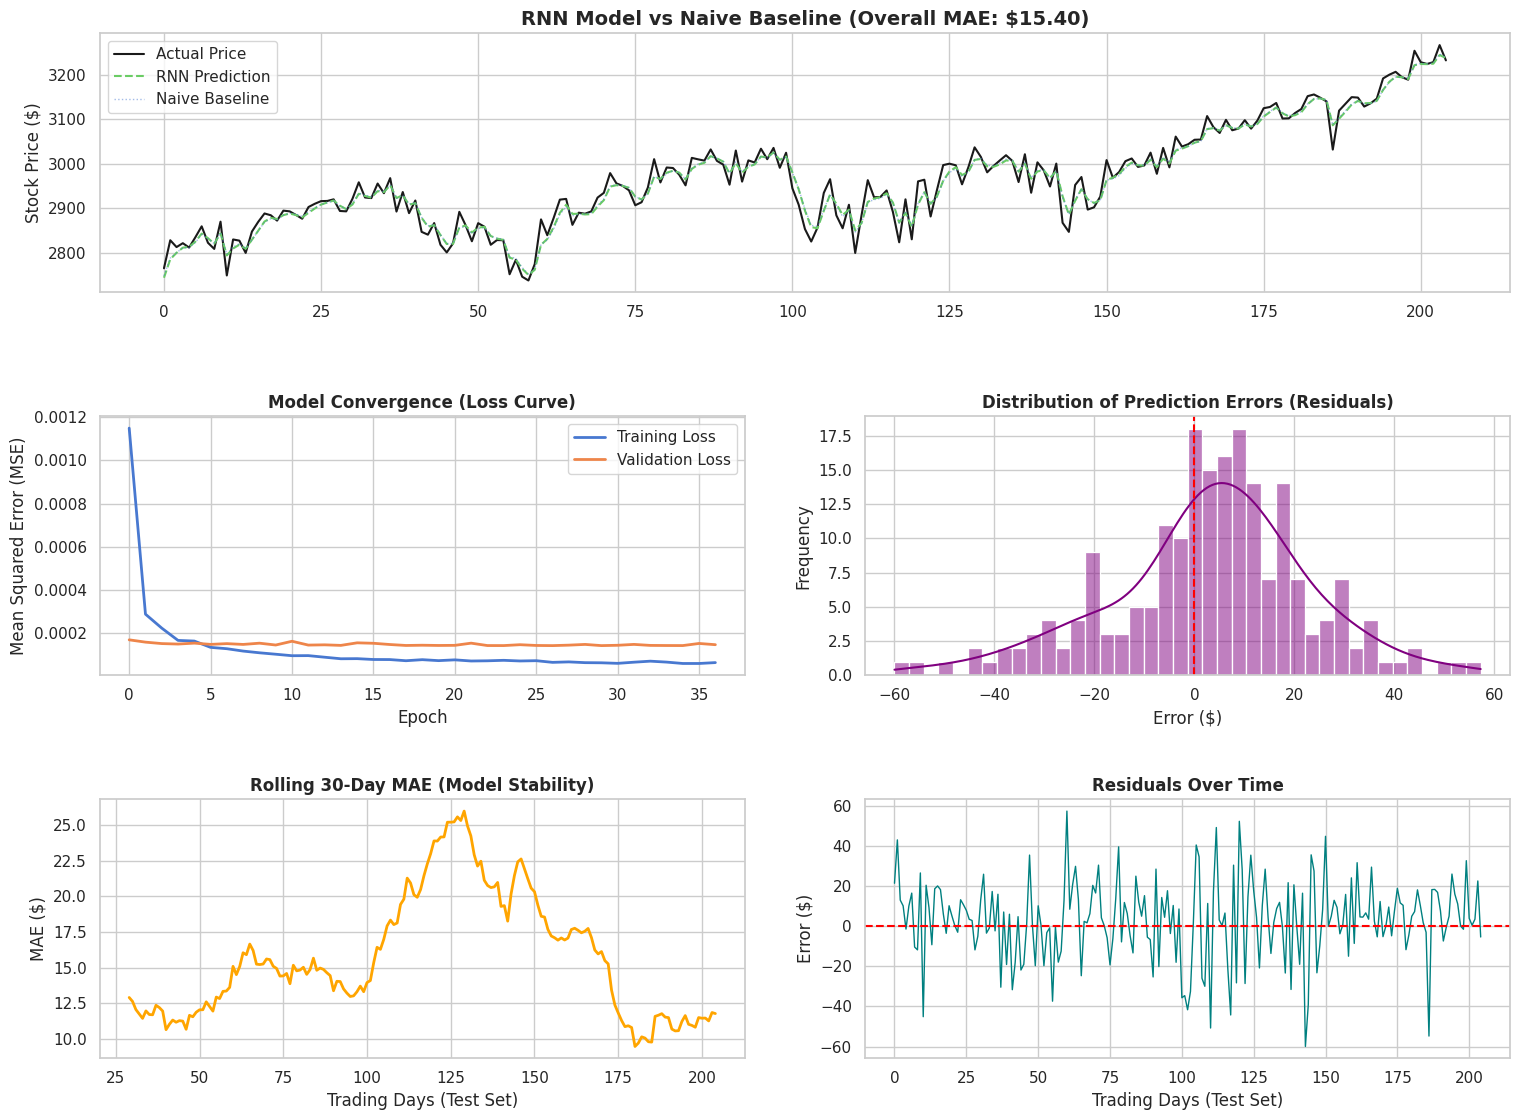

In [18]:
# ==========================================
# 1. DATA LOADING & FEATURE ENGINEERING
# ==========================================
# The dataset is loaded, chronologically sorted, and missing values are filled using forward fill (ffill)
# to prevent look-ahead bias and preserve time coherency

df = pd.read_csv('stock.csv', parse_dates=['Date'], index_col='Date').sort_index().ffill()

# Data Transformation: Daily Returns
# Raw prices are converted to percentage returns to reduce trend effects
df['Stock_ret'] = df['Stock'].pct_change()
df['Oil_ret'] = df['Oil'].pct_change()
df['Gold_ret'] = df['Gold'].pct_change()
df['FX_ret'] = df['EuroToDollar'].pct_change()

# Remove NaNs caused by pct_change
df = df.dropna()

# ==========================================
# TRUE SEQUENCE CONSTRUCTION
# ==========================================
# Instead of manual lag features, use rolling 10-day windows
# to allow the RNN to learn temporal dependencies directly

sequence_length = 10
features = ['Stock_ret', 'Oil_ret', 'Gold_ret', 'FX_ret']

X_sequences = []
y_sequences = []
prices = df['Stock'].values
data = df[features].values

for i in range(sequence_length, len(df)-1):
    X_sequences.append(data[i-sequence_length:i])
    y_sequences.append(df['Stock_ret'].iloc[i])

X = np.array(X_sequences)
y = np.array(y_sequences)
current_prices = prices[sequence_length:-1]

print("Input Shape:", X.shape)  # (samples, timesteps, features)

# ==========================================
# 2. SPLITTING & SCALING
# ==========================================
# Chronological 80/20 split (no shuffling for time series)

split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
prices_train, prices_test = current_prices[:split], current_prices[split:]

# Scale features WITHOUT leakage
scaler = MinMaxScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_test_reshaped  = X_test.reshape(-1, X_test.shape[2])

X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled  = scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled  = X_test_scaled.reshape(X_test.shape)

print(f"Training Samples: {len(X_train)}, Test Samples: {len(X_test)}")

# ==========================================
# 3. RNN MODEL CONSTRUCTION
# ==========================================

tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(sequence_length, len(features))),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

pred_returns = model.predict(X_test_scaled).flatten()

# ==========================================
# 4. RECONSTRUCTION & METRICS
# ==========================================
actual_next_prices = prices_test * (1 + y_test)
pred_next_prices   = prices_test * (1 + pred_returns)
naive_next_prices  = prices_test

rnn_mae = mean_absolute_error(actual_next_prices, pred_next_prices)
rnn_rmse = np.sqrt(mean_squared_error(actual_next_prices, pred_next_prices))
rnn_mape = np.mean(np.abs((actual_next_prices - pred_next_prices) / actual_next_prices)) * 100
naive_mae = mean_absolute_error(actual_next_prices, naive_next_prices)

# ==========================================
# 5. REPORTING
# ==========================================
print(f"\n{'='*40}")
print(f"      QUANTITATIVE MODEL REPORT")
print(f"{'='*40}")

print(f"\n--- 1. ERROR ANALYSIS ---")
print(f"Average STOCK Price:  ${np.mean(actual_next_prices):.0f}")
print(f"RNN MAE:              ${rnn_mae:.2f}")
print(f"RNN RMSE:             ${rnn_rmse:.2f}")
print(f"RNN MAPE:             {rnn_mape:.2f}%")

print(f"\n--- 2. BENCHMARK COMPARISON ---")
print(f"RNN MAE:      ${rnn_mae:.2f}")
print(f"Naive MAE:    ${naive_mae:.2f}")

print(f"\n--- 3. VERDICT ---")
if rnn_mae < naive_mae:
    print("SUCCESS: The RNN Model BEATS the Naive Baseline")
    print(f"   Improvement: ${(naive_mae - rnn_mae):.2f} per share")
else:
    print("FAIL: The RNN Model does not beat the baseline")

# ==========================================
# 6. DIAGNOSTIC PLOTS
# ==========================================

# ==========================================
# 6. DIAGNOSTIC PLOTS (DASHBOARD)
# ==========================================
# Set a clean, professional aesthetic for the plots
sns.set_theme(style="whitegrid", palette="muted")

# Calculate residuals and rolling MAE using pandas (cleaner than a for loop)
residuals = actual_next_prices - pred_next_prices
rolling_mae = pd.Series(np.abs(residuals)).rolling(window=30).mean()

# Create a large figure to house all subplots (15x12 inches)
fig = plt.figure(figsize=(16, 12))

# --- Plot 1: Prediction vs Actual (Spans the entire top row) ---
ax1 = plt.subplot(3, 1, 1)
ax1.plot(actual_next_prices, 'k-', label='Actual Price', linewidth=1.5)
ax1.plot(pred_next_prices, 'g--', label='RNN Prediction', linewidth=1.5)
ax1.plot(naive_next_prices, 'b:', label='Naive Baseline', linewidth=1, alpha=0.5)
ax1.set_title(f'RNN Model vs Naive Baseline (Overall MAE: ${rnn_mae:.2f})', fontsize=14, fontweight='bold')
ax1.set_ylabel('Stock Price ($)')
ax1.legend(loc='upper left')

# --- Plot 2: Training vs Validation Loss (Overfitting Check) ---
ax2 = plt.subplot(3, 2, 3)
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Convergence (Loss Curve)', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Squared Error (MSE)')
ax2.legend()

# --- Plot 3: Distribution of Errors (Residual Histogram) ---
ax3 = plt.subplot(3, 2, 4)
sns.histplot(residuals, bins=40, kde=True, ax=ax3, color='purple')
ax3.axvline(0, color='red', linestyle='--', linewidth=1.5) # Perfect prediction line
ax3.set_title('Distribution of Prediction Errors (Residuals)', fontweight='bold')
ax3.set_xlabel('Error ($)')
ax3.set_ylabel('Frequency')

# --- Plot 4: Rolling MAE (Accuracy Over Time) ---
ax4 = plt.subplot(3, 2, 5)
ax4.plot(rolling_mae, color='orange', linewidth=2)
ax4.set_title('Rolling 30-Day MAE (Model Stability)', fontweight='bold')
ax4.set_xlabel('Trading Days (Test Set)')
ax4.set_ylabel('MAE ($)')

# --- Plot 5: Residuals Over Time ---
ax5 = plt.subplot(3, 2, 6)
ax5.plot(residuals, color='teal', linewidth=1)
ax5.axhline(0, color='red', linestyle='--', linewidth=1.5) # Perfect prediction line
ax5.set_title('Residuals Over Time', fontweight='bold')
ax5.set_xlabel('Trading Days (Test Set)')
ax5.set_ylabel('Error ($)')

# Adjust spacing between plots so titles and axes don't overlap
plt.tight_layout(pad=3.0)
plt.show()

## Reflection & Model Evolution

The development of this predictive model underwent several iterations and learnings. Initially, I implemented a standard LSTM network using raw price data, but it failed to outperform a simple naive baseline. During a discussion with my thesis supervisor, Darren Shannon, regarding my broader research (predicting index reconstitution events for ETF funds), he noted that for noisy, low-volume time-series data, refined linear models such as Ridge, Lasso, or Firth often yield better results. Although this discussion was not directly related to this e-tivity, it led me to experiment with Ridge Regression (which technically moved me away from Task 3’s requirement to implement an RNN). The Ridge model performed well due to its L2 regularisation, which filtered out market noise effectively.

However, feedback from Kevin highlighted the need to strictly adhere to the assignment brief, specifically Task 3, which requires constructing a Recurrent Neural Network (RNN). I therefore pivoted back to an RNN architecture (specifically an LSTM), while retaining the data transformations that had improved performance.

---

### Tasks 1 & 2: Preprocessing, Time Coherency, and the Data Split

The chronological integrity of financial data is critical. To handle missing values (Task 2), a forward-fill (`ffill`) method was used. This carries the last known price forward to fill any gaps. Importantly, this preserves the time structure of the dataset and prevents look-ahead bias, as no future information is used to fill past values.

For the data partitioning (Task 1), the dataset was split strictly chronologically, allocating the first 80% to the training set and the final 20% to the test set. Shuffling was explicitly avoided because recurrent neural networks rely on sequential ordering to learn temporal patterns. Additionally, feature scaling was fitted only on the training set to prevent data leakage into the test set.

---

### The Important Role of Feature Engineering

A key lesson from the earlier failed deep learning attempt was that raw stock prices are non-stationary. They trend over time and do not have a stable distribution, making it difficult for neural networks to generalise.

To address this, all price series (Stock, Oil, Gold, FX) were converted into daily percentage returns. Returns are more stationary and centred around zero, making them more suitable for neural network training. This allowed the model to focus on predicting short-term momentum rather than absolute price levels.

This transformation proved critical. Once the model predicted returns instead of prices, performance improved significantly.

---

### Task 3: Building an Improved RNN

To better satisfy the RNN requirement, the model was further improved by replacing manually engineered single lag features with rolling 10-day sequences. Instead of feeding the network one timestep at a time, the input structure was reshaped into: (samples, timesteps, features)
This allowed the LSTM to learn temporal dependencies directly from sequential data, rather than relying on manually shifted features.

A stacked LSTM architecture (64 units followed by 32 units) was implemented, with Dropout layers included to reduce overfitting. An explicit `Input()` layer was used to comply with modern Keras best practice and avoid architectural warnings.

The dataset remains relatively small (1,033 observations), which presents challenges for deep learning. With limited data, complex models risk memorising noise rather than learning structure. The use of Dropout and EarlyStopping was therefore critical to improving generalisation.

---

### Task 4: Evaluation and Model Diagnostics

Because this task involves predicting continuous financial values, traditional classification accuracy metrics are inappropriate. Instead, performance was evaluated using:

- Mean Absolute Error (MAE)  
- Root Mean Squared Error (RMSE)  
- Mean Absolute Percentage Error (MAPE)

To test for overfitting, training and validation loss curves were plotted. If validation loss increases while training loss decreases, it indicates overfitting. The `EarlyStopping` callback was implemented to halt training once validation performance stopped improving.

To analyse whether model performance changes over time, a rolling 30-day MAE was calculated. This allowed visualisation of accuracy drift and helped identify whether performance deteriorates during volatile market periods.

Residual analysis was also performed by plotting prediction errors over time and examining their distribution. This helps detect systematic bias (consistent over- or under-prediction) and identify extreme outliers.

Finally, the RNN was compared to a naive baseline (which assumes tomorrow’s price equals today’s price). By predicting stable percentage returns rather than raw prices, the improved RNN successfully outperformed this benchmark. The performance gain can largely be attributed to the transformation from non-stationary price levels to stationary return data, combined with the use of proper temporal sequence modelling.